# TP1 - EJERCICIO 3

**INTEGRANTES:**
* AGUSTIN ARENAS
* SOL KIDONAKIS


**AÑO:** 2024

## BIBLIOTECAS

In [ ]:
pip install numpy matplotlib pandas tensorflow seaborn scikit-learn imbalanced-learn


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Rescaling
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from PIL import Image
from pathlib import Path
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import MaxPooling2D


In [4]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## PROBLEMA 3

### ANALISIS EXPLORATORIO Y PREPROCESAMIENTO DEL SET DE DATOS

In [5]:


TRAIN_DATA_DIRECTORY = Path("C:/Users/USER/Documents/AA2/AA2TP1/EJ3/TP1-3-natural-scenes/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("C:/Users/USER/Documents/AA2/AA2TP1/EJ3/TP1-3-natural-scenes/seg_test/seg_test")


# Tamaño del lote (batch size)
BATCH_SIZE = 64

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [6]:
# Clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Visualizar los datos:

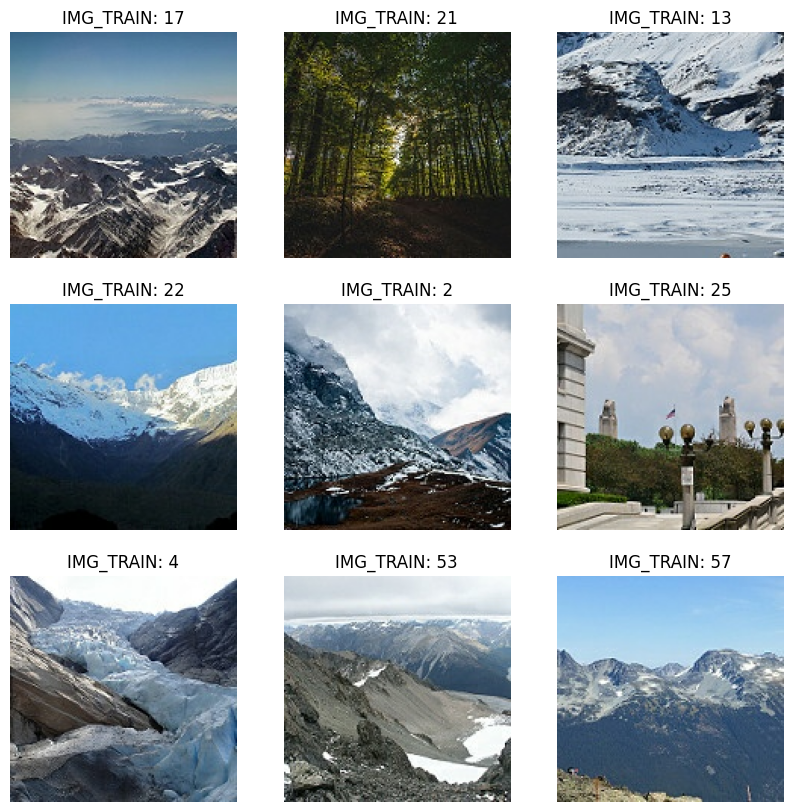

In [7]:
plt.figure(figsize=(10, 10))
for batch in train_ds.take(1):  # Toma un lote
    images, labels = batch  # Separa las imágenes de las etiquetas
    random_indices = np.random.choice(len(images), 9, replace=False)  # Selecciona 9 índices aleatorios sin reemplazo
    for i, idx in enumerate(random_indices):  # Itera sobre índices aleatorios
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx].numpy().astype("uint8"))  # Convierte a uint8 para mostrar
        plt.title(f"IMG_TRAIN: {idx}")
        plt.axis("off")

In [8]:
class_counts = {}
for class_folder in TRAIN_DATA_DIRECTORY.iterdir():
    if class_folder.is_dir():
        class_name = class_folder.name
        num_images = len(list(class_folder.glob("*.jpg")))
        class_counts[class_name] = num_images
print(class_counts)


{'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


### DEFINICION Y ENTRENAMIENTO DEL MODELO

Función para plotear el entrenamiento de los modelos

In [9]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title(title)
    plt.legend()
    plt.show()

#### **Modelo con Capas Densas**

In [10]:

dense_model = models.Sequential([
    layers.Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    Rescaling(1./255),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(6, activation="softmax"),
])

# Compilación
dense_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Resumen
dense_model.summary()



c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,654,822 (33.02 MB)

 Trainable params: 8,654,822 (33.02 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [12]:
# Entrenamos el modelo
history_dense = dense_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - accuracy: 0.3269 - loss: 2.1172 - val_accuracy: 0.4583 - val_loss: 1.4410
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.4771 - loss: 1.3651 - val_accuracy: 0.4410 - val_loss: 1.4305
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.4991 - loss: 1.3112 - val_accuracy: 0.5000 - val_loss: 1.2893
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.5394 - loss: 1.2111 - val_accuracy: 0.5047 - val_loss: 1.2852
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.5412 - loss: 1.2056 - val_accuracy: 0.5240 - val_loss: 1.2627
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.5528 - loss: 1.1855 - val_accuracy: 0.5460 - val_loss: 1.2000
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.5794 - loss: 1.1101 - val_accuracy: 0.5370 - val_loss: 1.2442
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 109ms/step - accuracy: 0.5878 - loss: 1.1021 

In [13]:
# Evaluamos el modelo
dense_loss, dense_acc = dense_model.evaluate(val_ds)
print(f"Precisión del modelo denso en validación: {dense_acc}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5647 - loss: 1.1900
Precisión del modelo denso en validación: 0.559333324432373


Predecir en nuevas imágenes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


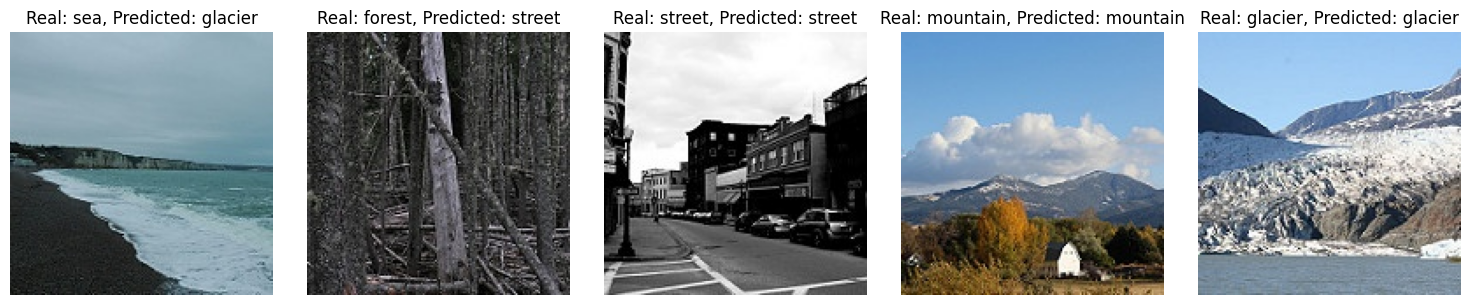

In [15]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("C:/Users/USER/Documents/AA2/AA2TP1/EJ3/TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)

    # Realizar la predicción
    prediction = dense_model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

#### **Modelo con Capas Convolucionales y Densas**

In [16]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [18]:
# Entrenar el modelo CNN
history_cnn = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 102s 456ms/step - accuracy: 0.3231 - loss: 29.9121 - val_accuracy: 0.5163 - val_loss: 1.3031
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 86s 391ms/step - accuracy: 0.5624 - loss: 1.1232 - val_accuracy: 0.6183 - val_loss: 0.9743
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 90s 407ms/step - accuracy: 0.6331 - loss: 0.9476 - val_accuracy: 0.6247 - val_loss: 1.0315
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 123s 562ms/step - accuracy: 0.6876 - loss: 0.8099 - val_accuracy: 0.6397 - val_loss: 1.0256
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 152s 689ms/step - accuracy: 0.7426 - loss: 0.6797 - val_accuracy: 0.6660 - val_loss: 0.9203
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 116s 525ms/step - accuracy: 0.7795 - loss: 0.5886 - val_accuracy: 0.6810 - val_loss: 0.9841
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 88s 398ms/step - accuracy: 0.8282 - loss: 0.4602 - val_accuracy: 0.6743 - val_loss: 1.1388
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 89s 403ms/step - accuracy: 0.8758 - lo

In [19]:
# Evaluamos el modelo
cnn_loss, cnn_acc = cnn_model.evaluate(val_ds)
print(f"Precisión del modelo CNN en validación: {cnn_acc}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.6632 - loss: 0.9414
Precisión del modelo CNN en validación: 0.6660000085830688


Predecir en nuevas imágenes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


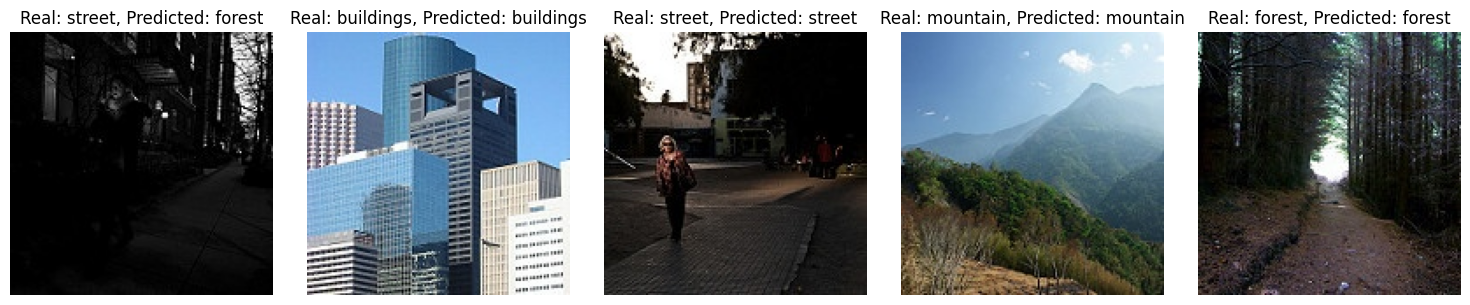

In [30]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("C:/Users/USER/Documents/AA2/AA2TP1/EJ3/TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)

    # Realizar la predicción
    prediction = cnn_model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

#### **Modelo con Bloques Residuales (ResNet)**

In [34]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, use_projection=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')
        self.conv2 = layers.Conv2D(filters, (3, 3), padding='same', activation=None)
        self.activation = layers.Activation('relu')
        self.use_projection = use_projection
        if use_projection:
            self.projection = layers.Conv2D(filters, (1, 1), padding='same', activation=None)

    def call(self, inputs):
        shortcut = inputs
        if self.use_projection:
            shortcut = self.projection(inputs)
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = layers.add([x, shortcut])
        x = self.activation(x)
        return x

In [ ]:

# Construcción del Modelo Residual 

residual_model = models.Sequential([
    # Entrada
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    # Bloque Residual 1 (sin proyección)
    ResidualBlock(32, use_projection=False),

    # Bloque Residual 2 (con proyección)
    ResidualBlock(64, use_projection=True),
    layers.MaxPooling2D((2, 2)),

    # Capa de salida densa
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')  
])

# Compilación del Modelo
residual_model.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Resumen del Modelo
residual_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 74, 74, 32)     │        18,496 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (None, 74, 74, 64)     │        57,536 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,684,806 (21.69 MB)

 Trainable params: 5,684,806 (21.69 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [37]:
# Entrenar el modelo
history_residual = residual_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 219s 979ms/step - accuracy: 0.3881 - loss: 114.5634 - val_accuracy: 0.5207 - val_loss: 1.2433
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 181s 822ms/step - accuracy: 0.5537 - loss: 1.1391 - val_accuracy: 0.5743 - val_loss: 1.1183
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 179s 811ms/step - accuracy: 0.6258 - loss: 0.9921 - val_accuracy: 0.5800 - val_loss: 1.1244
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 178s 809ms/step - accuracy: 0.6885 - loss: 0.8358 - val_accuracy: 0.5597 - val_loss: 1.3329
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 180s 818ms/step - accuracy: 0.7317 - loss: 0.7102 - val_accuracy: 0.6060 - val_loss: 1.2316
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 174s 792ms/step - accuracy: 0.8023 - loss: 0.5391 - val_accuracy: 0.6253 - val_loss: 1.3455
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 175s 794ms/step - accuracy: 0.8467 - loss: 0.4256 - val_accuracy: 0.5980 - val_loss: 1.5656
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 183s 833ms/step - accuracy: 0.8728

In [39]:
# Evaluar el modelo en el conjunto de validación
residual_loss, residual_acc = residual_model.evaluate(val_ds)
print(f"Precisión del modelo con Bloques residuales en validación: {residual_acc}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.5790 - loss: 1.1205
Precisión del modelo con Bloques residuales en validación: 0.5743333101272583


Predecir en nuevas imágenes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


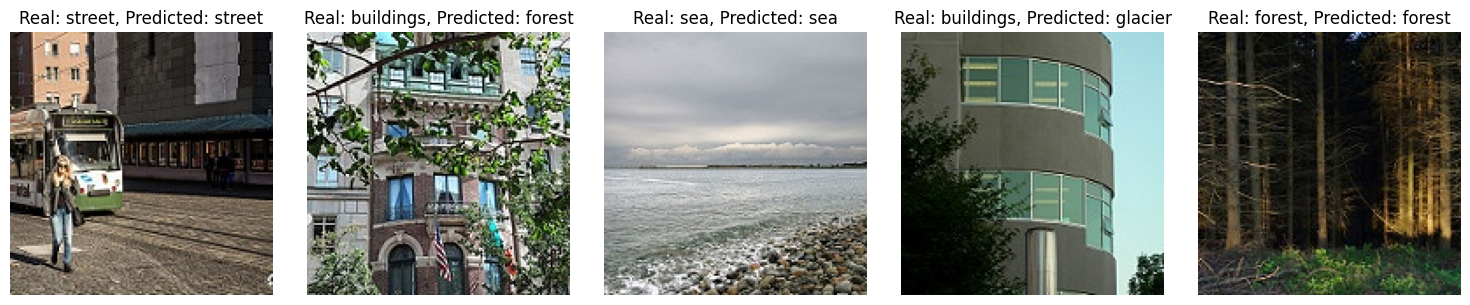

In [40]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("C:/Users/USER/Documents/AA2/AA2TP1/EJ3/TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)

    # Realizar la predicción
    prediction = residual_model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

#### **Modelo con Transfer Learning**

In [41]:
# Verificar la forma de las imágenes
for images, labels in train_ds.take(1):
    print(f"Tamaño de las imágenes: {images.shape}")
    print(f"Tamaño de las etiquetas: {labels.shape}")

Tamaño de las imágenes: (64, 150, 150, 3)
Tamaño de las etiquetas: (64, 6)


In [42]:
# Definición del bloque Inception
def inception_block(input_tensor, filters):
    # Ramas del bloque
    branch1x1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(input_tensor)
    
    branch3x3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(input_tensor)
    branch3x3 = layers.Conv2D(filters[1], (3, 3), padding='same', activation='relu')(branch3x3)
    
    branch5x5 = layers.Conv2D(filters[2], (1, 1), padding='same', activation='relu')(input_tensor)
    branch5x5 = layers.Conv2D(filters[2], (5, 5), padding='same', activation='relu')(branch5x5)
    
    branch_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    branch_pool = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(branch_pool)
    
    # Concatenar las ramas
    output = layers.concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
    return output


In [50]:
# Cargar VGG16 como backbone sin las capas superiores
vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

# Congelar las capas del modelo base
vgg_base.trainable = False

# Construcción del modelo
input_tensor = layers.Input(shape=(150, 150, 3))

# Pasar la entrada a través del modelo base (VGG16)
x = vgg_base(input_tensor)

# Añadir el primer bloque Inception
x = inception_block(x, [32, 64, 16, 16])
# Reducir la dimensionalidad
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

# Reducir dimensiones espaciales con Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)


# Añadir capas densas finales
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Dropout para evitar el sobreajuste
output_tensor = layers.Dense(6, activation='softmax')(x)  

# Crear el modelo final
inception_vgg_model = models.Model(inputs=input_tensor, outputs=output_tensor)

# Compilar el modelo
inception_vgg_model.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Resumen del modelo
inception_vgg_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 4, 4, 512) │ 14,714,688 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 4, 4, 64)  │     32,832 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 4, 4, 16)  │      8,208 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 4, 4, 512) │          0 │ vgg16[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 4, 4, 32)  │     16,416 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 4, 4, 64)  │     36,928 │ conv2d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 4, 4, 16)  │      6,416 │ conv2d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 4, 4, 16)  │      8,208 │ max_pooling2d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 4, 4, 128) │          0 │ conv2d_42[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_44[0][0],  │
│                     │                   │            │ conv2d_46[0][0],  │
│                     │                   │            │ conv2d_47[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 2, 2, 128) │          0 │ concatenate_4[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_17… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 6)         │        390 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,832,342 (56.58 MB)

 Trainable params: 117,654 (459.59 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [51]:
# Entrenar el modelo
history_transfer = inception_vgg_model.fit(
    train_ds,               # Conjunto de entrenamiento
    validation_data=val_ds, # Conjunto de validación
    epochs=10,
    callbacks=[early_stopping])

Epoch 1/10


220/220 ━━━━━━━━━━━━━━━━━━━━ 824s 4s/step - accuracy: 0.5142 - loss: 3.8676 - val_accuracy: 0.8497 - val_loss: 0.4461
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 831s 4s/step - accuracy: 0.7906 - loss: 0.5846 - val_accuracy: 0.8700 - val_loss: 0.3800
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 847s 4s/step - accuracy: 0.8398 - loss: 0.4571 - val_accuracy: 0.8813 - val_loss: 0.3563
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 851s 4s/step - accuracy: 0.8711 - loss: 0.3693 - val_accuracy: 0.8813 - val_loss: 0.3467
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 859s 4s/step - accuracy: 0.8824 - loss: 0.3169 - val_accuracy: 0.8953 - val_loss: 0.3298
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 800s 4s/step - accuracy: 0.8975 - loss: 0.2852 - val_accuracy: 0.8953 - val_loss: 0.3319
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 816s 4s/step - accuracy: 0.9095 - loss: 0.2468 - val_accuracy: 0.8947 - val_loss: 0.3353
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 810s 4s/step - accuracy: 0.9125 - loss: 0.2303 - val_accuracy: 0.893

In [52]:
# Evaluar el modelo en el conjunto de validación
transfer_loss, transfer_acc = inception_vgg_model.evaluate(val_ds)
print(f"Precisión del modelo con Transfer Learning en validación: {transfer_acc}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.9010 - loss: 0.3152
Precisión del modelo con Transfer Learning en validación: 0.8953333497047424


Predecir en nuevas imágenes:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


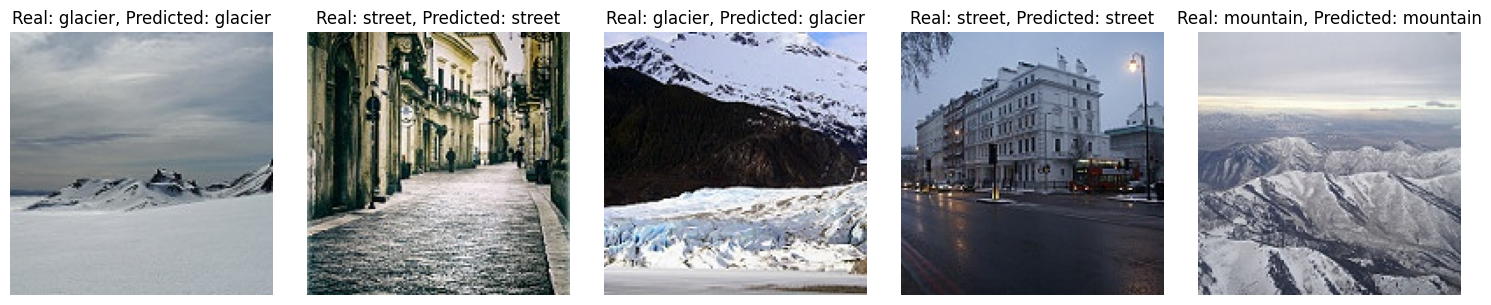

In [54]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("C:/Users/USER/Documents/AA2/AA2TP1/EJ3/TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)

    # Realizar la predicción
    prediction = inception_vgg_model.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

### COMPARAR Y EVALUAR LOS MODELOS

In [55]:
models_performance = {
    "Modelo Denso": dense_acc,
    "Modelo CNN": cnn_acc,
    "Modelo Residual": residual_acc,
    "Modelo Transfer Learning": transfer_acc
}

for model, acc in models_performance.items():
    print(f"{model}: {acc}")

Modelo Denso: 0.559333324432373
Modelo CNN: 0.6660000085830688
Modelo Residual: 0.5743333101272583
Modelo Transfer Learning: 0.8953333497047424


**Visualización de los Resultados**

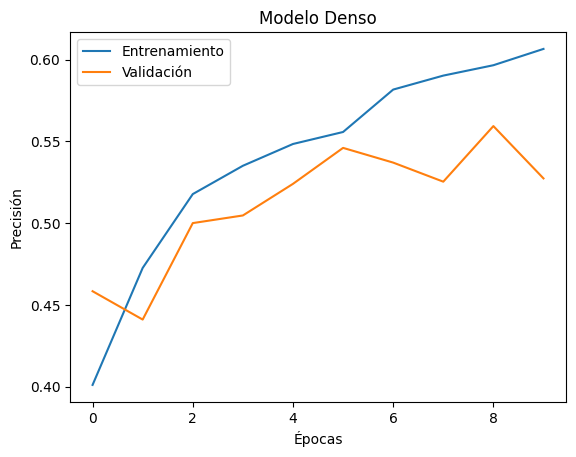

<Figure size 640x480 with 0 Axes>

In [56]:
# Gráficos de cada modelo
plot_history(history_dense, 'Modelo Denso')

# Ajuste del diseño para que no haya solapamiento
plt.tight_layout()
plt.show()

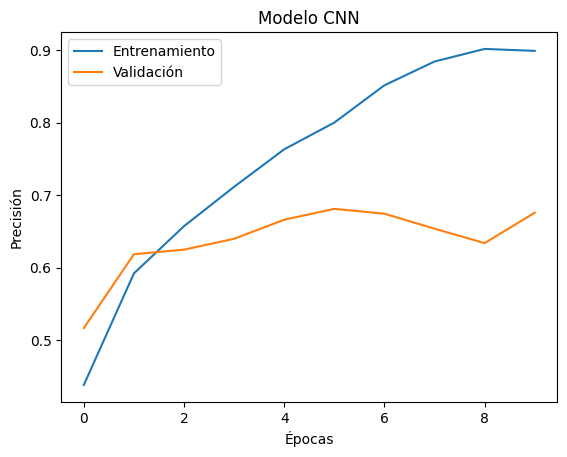

<Figure size 640x480 with 0 Axes>

In [57]:
# Gráficos de cada modelo
plot_history(history_cnn, 'Modelo CNN')

# Ajuste del diseño para que no haya solapamiento
plt.tight_layout()
plt.show()

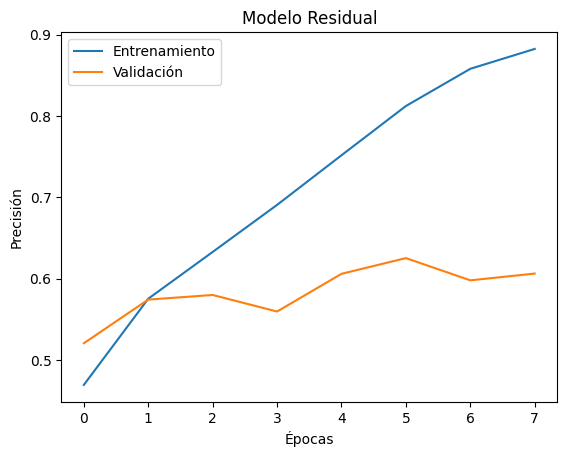

<Figure size 640x480 with 0 Axes>

In [58]:
# Gráficos de cada modelo
plot_history(history_residual, 'Modelo Residual')

# Ajuste del diseño para que no haya solapamiento
plt.tight_layout()
plt.show()

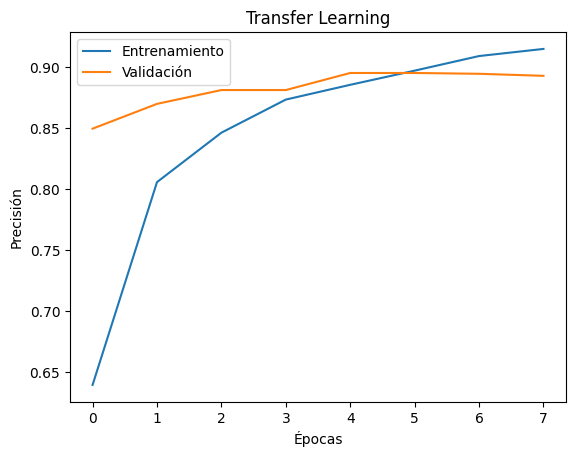

<Figure size 640x480 with 0 Axes>

In [59]:
# Gráficos de cada modelo
plot_history(history_transfer, 'Transfer Learning')

# Ajuste del diseño para que no haya solapamiento
plt.tight_layout()
plt.show()

## CONCLUSIONES

Con respecto a las gráficas y las predicciones se puede concluir:

1. Modelo Denso

Observación de la gráfica:
La precisión de entrenamiento aumenta de forma constante.
La precisión de validación también mejora inicialmente, pero tiene un comportamiento erratico e incluso decrece ligeramente al final.
Esto podría ser indicativo de sobreajuste después de unas pocas épocas.
Precisión final: 0.5593
Este modelo tiene la precisión más baja de todos, lo que sugiere que no captura adecuadamente las características del conjunto de datos.

2. Modelo CNN
Observación de la gráfica:
La precisión de entrenamiento sube de manera constante hasta valores altos (cercanos a 0.9).
La precisión de validación mejora al principio pero comienza a descender después de algunas épocas, mostrando un comportamiento claro de sobreajuste.
Precisión final: 0.6660
Este modelo es mejor que el denso, indicando que las convoluciones ayudan a capturar características importantes del conjunto de datos.

3. Modelo Residual
Observación de la gráfica:
La precisión de entrenamiento sube rápidamente y alcanza valores altos (~0.9).
La precisión de validación mejora inicialmente, pero se estabiliza e incluso decrece ligeramente hacia el final.
Este comportamiento también sugiere sobreajuste, aunque menos pronunciado que en el CNN.
Precisión final: 0.5743
Aunque tiene una precisión mejor que el modelo denso, no supera al modelo CNN. Esto indica que la arquitectura residual no fue plenamente aprovechada.

4. Modelo de Transfer Learning
Observación de la gráfica:
La precisión de entrenamiento y validación suben rápidamente y se mantienen cercanas (~0.9).
Podemos ver que el modelo se beneficia de características preentrenadas y generaliza mejor al conjunto de validación.
Precisión final: 0.8953
Este es el modelo más preciso, lo que demuestra que Transfer Learning es una solución poderosa.

